In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import starfish
from starfish import data, FieldOfView
from starfish.types import Axes, FunctionSource, Features

In [2]:
# load example iss dataset from starfish
experiment = data.ISS(use_test_data=False)
# i = '00' #select fov \in {00,01,...,15}
# fov = experiment['fov_0'+i]
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)
dots = fov.get_image("dots")
nuclei = fov.get_image("nuclei")

In [3]:
# filter and register raw data using starfish pipline
from starfish.image import Filter
from starfish.image import ApplyTransform, LearnTransform

masking_radius = 5
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)
filt.run(dots, verbose=True, in_place=True)

learn_translation = LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(imgs.reduce({Axes.CH, Axes.ZPLANE}, func="max"))
warp = ApplyTransform.Warp()
registered_imgs = warp.run(filtered_imgs, transforms_list=transforms_list, in_place=False, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 176.27it/s]


In [4]:
# detect spots via starfish's BlobDetector
import warnings
from starfish.spots import FindSpots, DecodeSpots

bd = FindSpots.BlobDetector(
    min_sigma=1,
    max_sigma=10,
    num_sigma=30,
    threshold=0.01,
    measurement_type='mean',
)
lmp = FindSpots.LocalMaxPeakFinder(#slower than the BlobDetector
    min_distance=2,
    stringency=7,
    min_obj_area=6,
    max_obj_area=50,
)

spot_detector = bd # select which spot detector to execute
dots_max = dots.reduce((Axes.ROUND, Axes.ZPLANE), func=FunctionSource.np("max"))#same as dots above since there's only one (reference) round for the anchor channel
spots_starfish = spot_detector.run(image_stack=registered_imgs, reference_image=dots_max)#detecting spots in the anchor channel from the reference round

100%|██████████| 1/1 [00:00<00:00, 232.11it/s]


In [5]:
# decode spots via starfish's PerRoundMaxChannel (argmax)
decoder = DecodeSpots.PerRoundMaxChannel(codebook=experiment.codebook)
decoded = decoder.run(spots=spots_starfish)
genes, counts = np.unique(decoded.loc[decoded[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
table = pd.Series(counts, index=genes).sort_values(ascending=False)

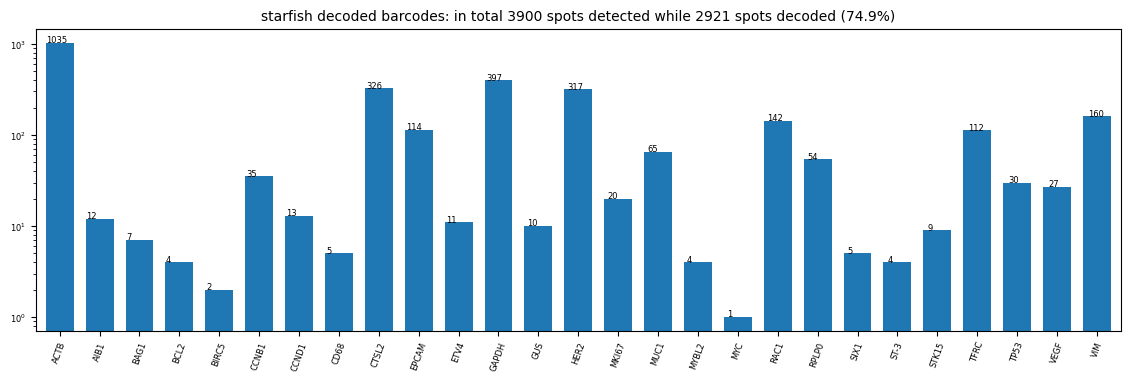

In [6]:
# plot starfish decoding results in a histogram
plt.figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')
ax = table.sort_index(axis=0).plot(kind='bar',width=0.7,rot=70,logy=True,fontsize=6,figsize=(14,4))
ax.set_facecolor('w')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('starfish decoded barcodes: in total {} spots detected while {} spots decoded ({}%)'.format(list(spots_starfish.values())[0].spot_attrs.data.spot_id.size,counts.sum(),np.round(100*counts.sum()/list(spots_starfish.values())[0].spot_attrs.data.spot_id.size, 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + 'starfish_histogram.png')
plt.show()

In [7]:
# collect spots, spots_loc and barcodes from starfish in the required numpy format for gmm-decoding
from starfish.core.spots.DecodeSpots.trace_builders import build_spot_traces_exact_match
bd_table = build_spot_traces_exact_match(spots_starfish)
spots = np.swapaxes(bd_table.data,1,2)
N = spots.shape[0]
X = np.array(bd_table.x)
Y = np.array(bd_table.y)
spots_loc = pd.DataFrame(np.concatenate((X.reshape((N, 1)), Y.reshape((N, 1))), axis=1), columns=['X', 'Y'], index=None)
barcodes_01 = np.swapaxes(np.array(experiment.codebook), 1, 2)
K = barcodes_01.shape[0]

In [8]:
# gmm-decoding
from decoding_functions import *
# estimate GMM parameters and compute class probabilities 
out = decoding_function(spots, barcodes_01, print_training_progress=True)
# creating a data frame from the decoding output
df_class_names = np.concatenate((experiment.codebook.target.values,['infeasible','background','nan']))
barcodes_0123 = np.argmax(np.array(experiment.codebook),axis=2)
channel_base=['T', 'G', 'C', 'A']
barcodes_AGCT = np.empty(K, dtype='object')
for k in range(K):
    barcodes_AGCT[k]=''.join(list(np.array(channel_base)[barcodes_0123[k,:]]))
df_class_codes = np.concatenate((barcodes_AGCT,['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

100%|██████████| 60/60 [00:02<00:00, 23.12it/s]


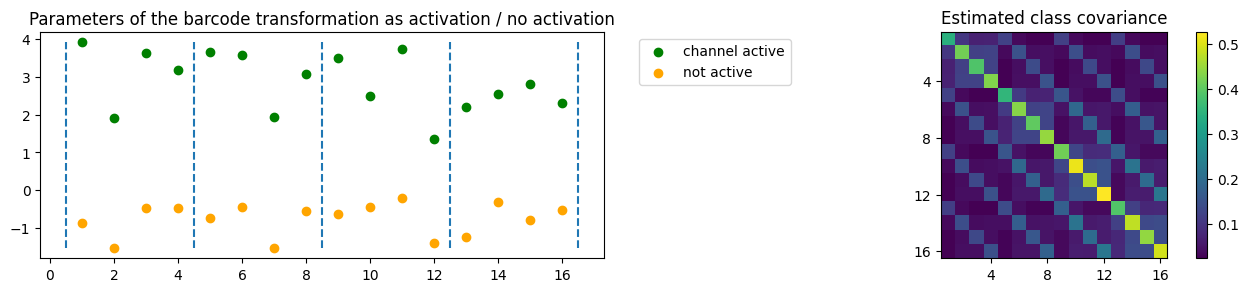

In [9]:
# plot gmm estimated parameters for class means and covariance
plt.figure(num=None, figsize=(16, 3), dpi=100, facecolor='w', edgecolor='k')
R = imgs.shape['r']
C = imgs.shape['c']
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,1+R*C),activation,c='green') 
plt.scatter(np.arange(1,1+R*C),no_activation,c='orange') 
plt.legend(('channel active','not active'),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
plt.title('Parameters of the barcode transformation as activation / no activation')
plt.subplot(1, 2, 2)
plt.imshow(out['params']['sigma_star'])
plt.yticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.xticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.colorbar()
plt.title('Estimated class covariance')
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_params.png')
plt.show()

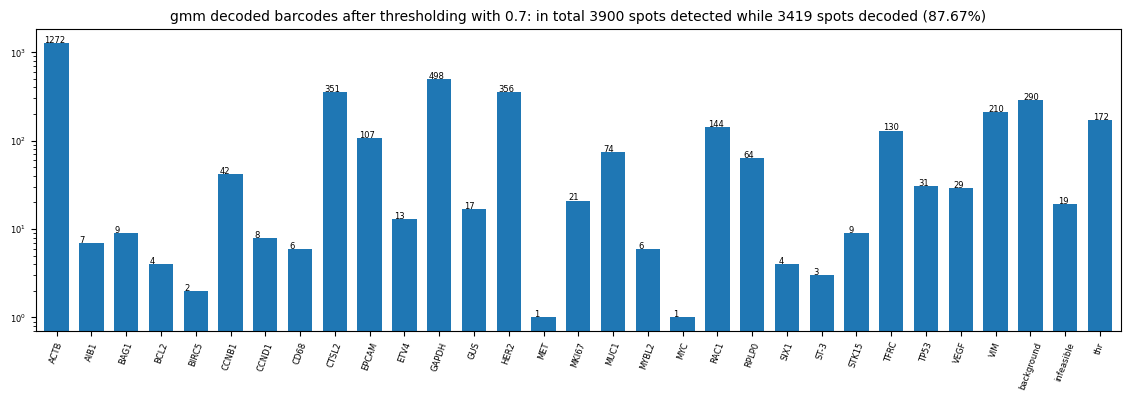

In [10]:
# plot histogram of gmm class assignments when class probabilities are thresholded by thr
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability >thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
plt.figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')
ax = df.plot(kind='bar',width=0.7,rot=70,logy=True,fontsize=6,figsize=(14,4))
ax.set_facecolor('w')
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('gmm decoded barcodes after thresholding with {}: in total {} spots detected while {} spots decoded ({}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df.shape[0], 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram.png')
plt.show()

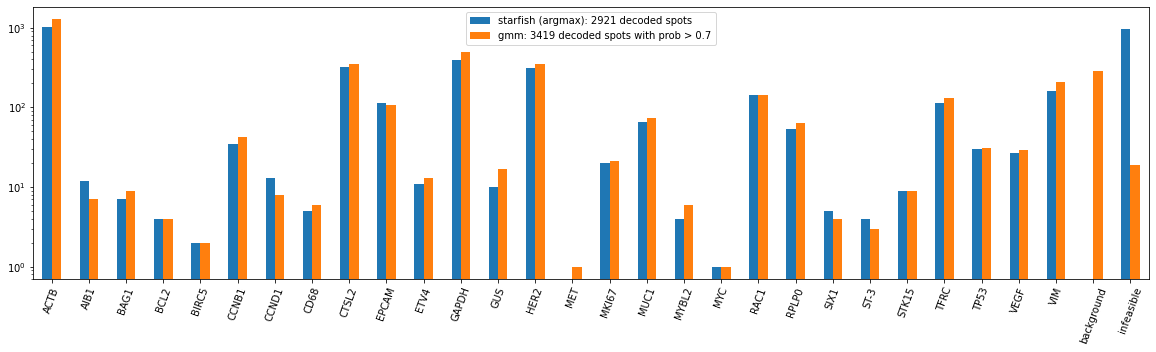

In [11]:
# compare histograms side by side
thr=0.7
df = pd.concat([table.append(pd.Series(N-counts.sum(), index=['infeasible'])),decoded_df.Name[decoded_df.Probability >thr].value_counts()], axis=1).sort_index(axis=0)
ax = df.plot(kind='bar',width=0.5,rot=70,logy=True,figsize=(20,5))
ax.set_facecolor('w')
ax.legend(["starfish (argmax): {} decoded spots".format(counts.sum()), "gmm: {} decoded spots with prob > {}".format(sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr)),thr)])        
plt.show()

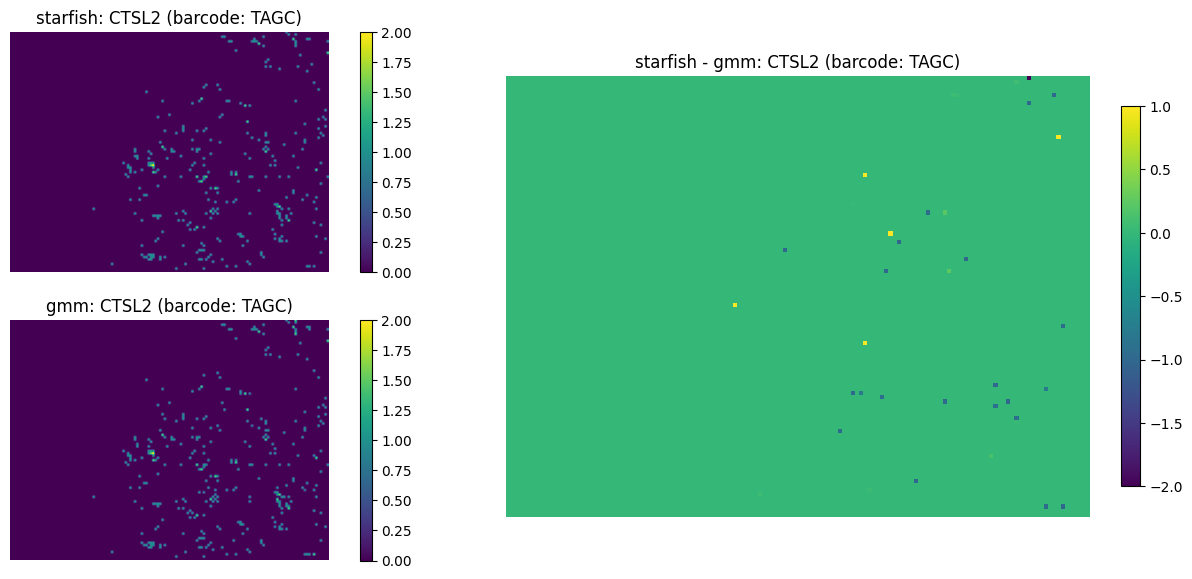

In [22]:
# plot any of the classes
name = 'CTSL2'
thr = 0.7
grid = 10
plot_probs = True
x_coord = np.floor(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
y_coord = np.floor(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
D_gmm = np.zeros((int(np.ceil(decoded_df.Y.to_numpy(dtype=np.double).max()/grid)),int(np.ceil(decoded_df.X.to_numpy(dtype=np.double).max()/grid))))
if plot_probs:
    prob = decoded_df.Probability[decoded_df.Name == name].to_numpy(dtype=np.double)
    prob[prob<thr]=0
    for i in range(len(x_coord)):
        D_gmm[y_coord[i],x_coord[i]] = D_gmm[y_coord[i],x_coord[i]] + prob[i]
else:
    coords = np.concatenate((y_coord.reshape((len(x_coord),1)),x_coord.reshape((len(x_coord),1))), axis=1)
    coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
    D_gmm[coords_u[:,0],coords_u[:,1]]=coords_c
    
D_starfish= np.zeros(D_gmm.shape)
is_gene = decoded.where(decoded[Features.AXIS][Features.TARGET] == name, drop=True)
x_coord = np.floor(np.array(is_gene.x)/grid).astype(np.int32)
y_coord = np.floor(np.array(is_gene.y)/grid).astype(np.int32)
N_g = len(x_coord)
coords = np.concatenate((y_coord.reshape((N_g,1)),x_coord.reshape((N_g,1))), axis=1)
coords[coords<0]=0
coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
D_starfish[coords_u[:,0],coords_u[:,1]]=coords_c    

plt.figure(num=None, figsize=(18, 7), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(2, 2, 1)
plt.imshow(np.log2(1+D_starfish),vmax=max(np.log2(1+D_starfish).max(),np.log2(1+D_gmm).max()))
plt.axis('off')
plt.colorbar(fraction=0.03)
plt.title('starfish: {} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
plt.subplot(2, 2, 3)
plt.imshow(np.log2(1+D_gmm),vmax=max(np.log2(1+D_starfish).max(),np.log2(1+D_gmm).max()))
plt.axis('off')
plt.colorbar(fraction=0.03)
plt.title('gmm: {} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
plt.subplot(1, 2, 2)
plt.imshow(D_starfish-D_gmm)
plt.axis('off')
plt.colorbar(fraction=0.03)
plt.title('starfish - gmm: {} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
#plt.savefig(os.getcwd() + '/out_imgs/' +'starfish_iss_decoded_' + name +'.png')
plt.show()

100%|██████████| 1/1 [00:00<00:00, 166.11it/s]


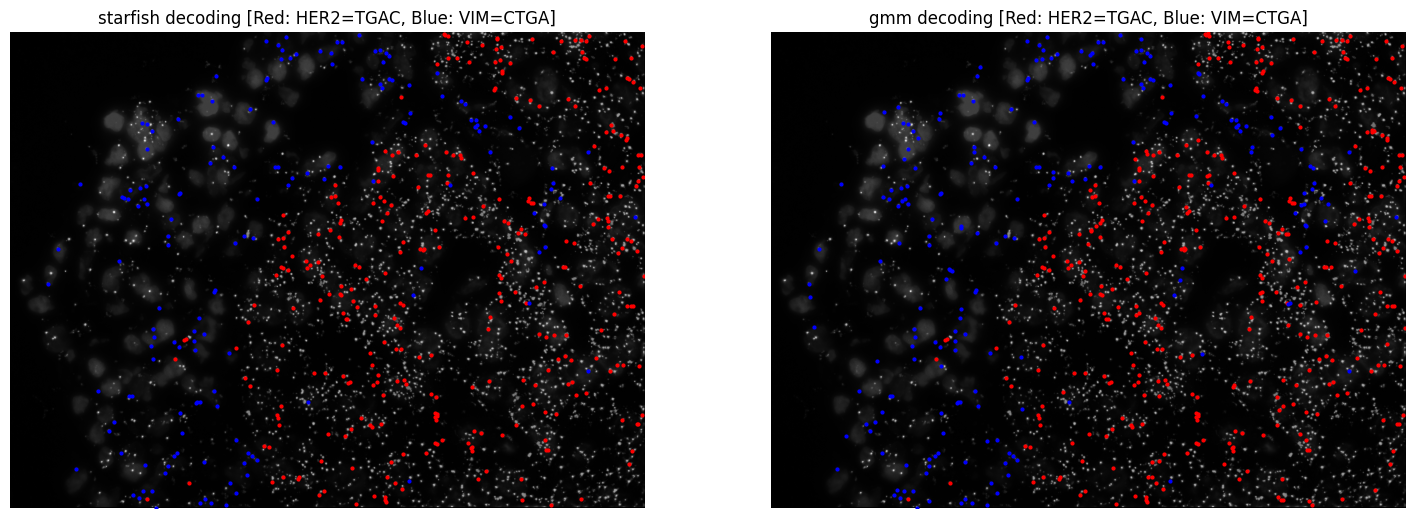

In [13]:
from skimage.color import rgb2gray

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(registered_imgs.tile_shape + (3,))
nuclei_numpy = nuclei.reduce({Axes.ROUND, Axes.CH, Axes.ZPLANE}, func="max")._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_numpy = dots.reduce({Axes.ROUND, Axes.CH, Axes.ZPLANE}, func="max")._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_numpy
do = rgb2gray(rgb)
do = do/(do.max())

plt.figure(num=None, figsize=(18, 7), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(do,cmap='gray')
plt.axis('off');
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)
plt.plot(is_gene1.x, is_gene1.y, 'or', markersize=2)
plt.plot(is_gene2.x, is_gene2.y, 'ob', markersize=2)
plt.title(f'starfish decoding [Red: {GENE1}={df_class_codes[df_class_names==GENE1][0]}, Blue: {GENE2}={df_class_codes[df_class_names==GENE2][0]}]');
plt.subplot(1, 2, 2)
plt.imshow(do,cmap='gray')
plt.axis('off');
x_coord_1 = decoded_df.X[(decoded_df.Name == GENE1) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
y_coord_1 = decoded_df.Y[(decoded_df.Name == GENE1) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
x_coord_2 = decoded_df.X[(decoded_df.Name == GENE2) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
y_coord_2 = decoded_df.Y[(decoded_df.Name == GENE2) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
plt.plot(x_coord_1, y_coord_1, 'or', markersize=2)
plt.plot(x_coord_2, y_coord_2, 'ob', markersize=2)
plt.title(f'gmm decoding [Red: {GENE1}={df_class_codes[df_class_names==GENE1][0]}, Blue: {GENE2}={df_class_codes[df_class_names==GENE2][0]}]');

In [14]:
# detect spots using local detect_and_extract_spots function 
from spot_detection_functions import *
imgs_np = np.swapaxes(np.array(registered_imgs.xarray.squeeze()).transpose(),0,1) #coding channels (Y x X x C x R)
#anchors = np.swapaxes(np.swapaxes(imgs_np.max(axis=2), 0, 2), 1, 2) #if to search spots on max-projected channels in each round
anchors = np.array(dots.xarray.squeeze()) #if to search spots on filtered anchor from the reference round
# detect and extract spots from the loaded tile
spots_tp, centers_tp, _ = detect_and_extract_spots(imgs_np, anchors, C, R, trackpy_prc=0)
spots_loc = pd.DataFrame(np.concatenate((centers_tp[:, 0].reshape((spots_tp.shape[0], 1)), centers_tp[:, 1].reshape((spots_tp.shape[0], 1))), axis=1), columns=['X', 'Y'], index=None)                 

In [15]:
# estimate GMM parameters and compute class probabilities 
out = decoding_function(spots_tp, barcodes_01, print_training_progress=True)
# creating a data frame from the decoding output
df_class_names = np.concatenate((experiment.codebook.target.values,['infeasible','background','nan']))
df_class_codes = np.concatenate((barcodes_AGCT,['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df2 = pd.concat([decoded_spots_df, spots_loc], axis=1) 

100%|██████████| 60/60 [00:02<00:00, 23.68it/s]


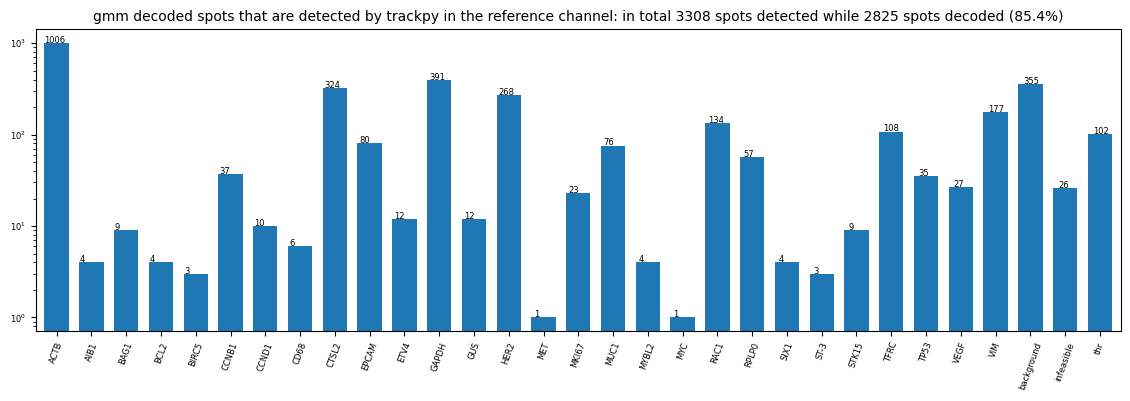

In [16]:
# plot histogram of gmm class assignments when class probabilities are thresholded by thr
thr=0.7
df = pd.concat([decoded_df2.Name[decoded_df2.Probability >thr].value_counts(), decoded_df2.Name[decoded_df2.Probability <=thr].replace(np.unique(decoded_df2.Name),'thr').value_counts()]).sort_index(axis=0)
plt.figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')
ax = df.plot(kind='bar',width=0.7,rot=70,logy=True,fontsize=6,figsize=(14,4))
ax.set_facecolor('w')
num_decoded_barcodes = sum((decoded_df2.Name!='background')&(decoded_df2.Name!='infeasible')&(decoded_df2.Name!='NaN')&(decoded_df2.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('gmm decoded spots that are detected by trackpy in the reference channel: in total {} spots detected while {} spots decoded ({}%)'.format(decoded_df2.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df2.shape[0], 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram.png')
plt.show()

In [17]:
# # compare histograms side by side
# thr=0.7
# df = pd.concat([decoded_df.Name[decoded_df.Probability >thr].value_counts(),decoded_df2.Name[decoded_df2.Probability >thr].value_counts()], axis=1).sort_index(axis=0)
# ax = df.plot(kind='bar',width=0.5,rot=70,logy=True,figsize=(20,5))
# ax.set_facecolor('w')
# ax.legend(["gmm using starfish spots: {} decoded spots".format(sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))), "gmm using trackpy spots: {} decoded spots".format(sum((decoded_df2.Name!='background')&(decoded_df2.Name!='infeasible')&(decoded_df2.Name!='NaN')&(decoded_df2.Probability>thr)))])        
# plt.show()